# EDSA - Climate Change Belief Analysis
#### Classification_TS3_DSFT21
------------------------------

<img src="images/Adaptacion_746x419.jpg"
     style="float: center; padding-bottom=0.5em"
     width=600px/>   
-------------------------------

## Table of Contents

1. <a href ="#1.-Challenge-description">Challenge description</a>
2. <a href ="#2.-Introduction">Introduction</a>
3. <a href ="#3.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#4.-Importing-Data">Importing Data</a>
5. <a href ="#5.-Data-Preprocessing">Data Preprocessing</a>
6. <a href ="#6.-Exploratory-Data-Analysis">Exploratory Data Analysis</a>


# 1. Challenge description

Many companies are built around lessening one's environmental impact or carbon foot print. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climante change and whether or not they belive it is a real threat. This would add to their market research efforts in gaugin how their product/service may be received.

With this context, EDSA is challending us during the Classification Sprint with the task of creating a Machine Learning mode that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to the task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Introduction

To achieve this, we shall perform preprocessing of the data, statistical and exploratory data analysis, construct multiple machine learning models, train our models with regards to the sentiment expressed by the user and of course testing our model on unseen data to verify the validity of our model.

# Start Comet Experiment

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="d4LPbs6tjAyPaNQcw3NFP2a29",
    project_name="ts3-classification",
    workspace="rlatndgb",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rlatndgb/ts3-classification/b7821e80bd994cbb9834ca1e933e9fde



# 3. Importing Libraries

In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [1]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline


# set plot style
sns.set(style = 'whitegrid')

In [3]:
#Downloading NLTK Corpora
nltk.download(['punkt','stopwords'])

#Downloading wordnet for lemmatisation
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 4. Importing Data

In [4]:
#Training set
train_df = pd.read_csv('data/train.csv')
#Test set
test_df = pd.read_csv('data/test.csv')

## 4.1 Data Overview

Our training set consist of 3 columns:
* The sentiment : Indicates the sentiment of the tweet message
* message : The body of the tweet
* tweetid : Twitter unique id

In [5]:
train_df.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

We look at the top rows of our data to the see the features as well as the types of data we are working with.

In [6]:
test_df.head()

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \r\nPu...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

Let us get the dimensions of our data to figure out how many observations we have.

In [7]:
print("Train data: ", train_df.shape)
print("Test data: ", test_df.shape)

Train data:  (15819, 3)
Test data:  (10546, 2)


We have 15 819 Observations in our data.

Let us get the types of sentiments that are there and their descriptions.

In [8]:
list(train_df['sentiment'].unique())

[1, 2, 0, -1]

There are three class namely :
* 1 Pro: the tweet supports the belief of man-made climate
* 2 News: the tweet links to factual news about climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Now Let's obtain the counts of each class of sentiments and plot them on a bar graph

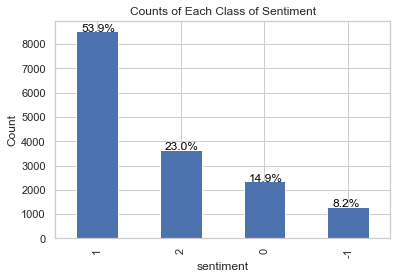

In [9]:
ax = train_df['sentiment'].value_counts().plot(kind = 'bar', 
                                          title = 'Counts of Each Class of Sentiment',
                                          xlabel = 'sentiment', 
                                          ylabel = 'Count')
n_obs = [i.get_height() for i in ax.patches]
total = sum(n_obs)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

From the figure above, we observed that we have unbalanced classes. 
* The majority of tweets (53.9%) support the belief of man-made climate change. 
* 23% consist of factual news regarding climate change. 
* 14.9% are neutral about man-made climate change
* 8.2% don't believe in man-made climate change

## Hashtag Extraction

Does Hashtags provide any meaningful insight into the sentiment?

In [10]:
def hash_ext(col):
    
    hashtags = []
    
    for i in col:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(10, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
pro_has = hash_ext(train_df['message'][train_df['sentiment'] == 1])
anti_has = hash_ext(train_df['message'][train_df['sentiment'] == -1])
neutral_has = hash_ext(train_df['message'][train_df['sentiment'] == 0])
news_has = hash_ext(train_df['message'][train_df['sentiment'] == 2])

In [11]:
anti_has.head(30)

hashtag  count
30            MAGA     11
48         climate     10
12           Trump      7
72   climatechange      6
7     OpChemtrails      4
27            tcot      4
52  ParisAgreement      4
3         fakenews      3
13           QandA      3
24     ClimateScam      3

## Mention Extraction

Similar to the hashtag extraction, we will see the top 10 mentions per class

In [12]:
def men_ext(col):
    
    mentions = []
    
    for i in col:
        men = re.findall(r"@(\w+)", i)
        mentions.append(men)
        
    mentions = sum(mentions, [])
    frequency = nltk.FreqDist(mentions)
    
    mention_df = pd.DataFrame({'Mention': list(frequency.keys()),
                       'count': list(frequency.values())})
    mention_df = mention_df.nlargest(10, columns="count")

    return mention_df

# Extracting the mentions from tweets in each class
pro_men = men_ext(train_df['message'][train_df['sentiment'] == 1])
anti_men = men_ext(train_df['message'][train_df['sentiment'] == -1])
neutral_men = men_ext(train_df['message'][train_df['sentiment'] == 0])
news_men = men_ext(train_df['message'][train_df['sentiment'] == 2])

In [13]:
pro_men.head()

Mention  count
6   StephenSchlegel    307
14       SenSanders    245
50  realDonaldTrump    164
40      LeoDiCaprio    129
22    BernieSanders    123

##  Quick EDA prior to data cleaning

### Proportion of url links

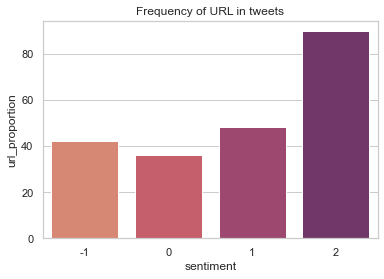

In [14]:
# Proportion of links in each class

url_df = train_df[train_df['message'].str.contains("http")]
url_df = (url_df.groupby('sentiment').count()/train_df.groupby('sentiment').count())*100
url_df['url_proportion'] = url_df['message']
url_df = url_df[['url_proportion']]

url_df.reset_index(level=0, inplace=True)
url_df

# Plotting 

sns.barplot(data=url_df,
            y=url_df['url_proportion'],
            x=url_df['sentiment'],
            palette='flare')

plt.title("Frequency of URL in tweets")
plt.show()

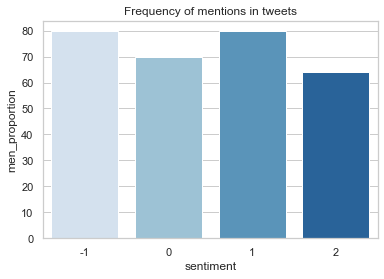

In [15]:
### Proportion of Mentions

men_df = train_df[train_df['message'].str.contains("@")]
men_df = (men_df.groupby('sentiment').count()/train_df.groupby('sentiment').count())*100
men_df['men_proportion'] = men_df['message']
men_df = men_df[['men_proportion']]

men_df.reset_index(level=0, inplace=True)
men_df

# Plotting 

sns.barplot(data=men_df,
            y=men_df['men_proportion'],
            x=men_df['sentiment'],
            palette='Blues')

plt.title("Frequency of mentions in tweets")
plt.show()

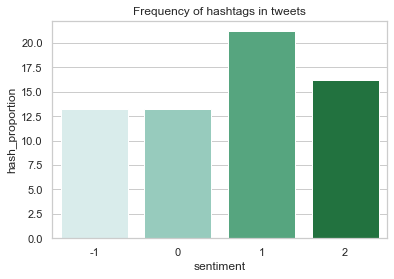

In [16]:
### Proportion of Hashtags

hash_df = train_df[train_df['message'].str.contains("#")]
hash_df = (hash_df.groupby('sentiment').count()/train_df.groupby('sentiment').count())*100
hash_df['hash_proportion'] = hash_df['message']
hash_df = hash_df[['hash_proportion']]

hash_df.reset_index(level=0, inplace=True)
hash_df

# Plotting 

sns.barplot(data=hash_df,
            y=hash_df['hash_proportion'],
            x=hash_df['sentiment'],
            palette='BuGn')

plt.title("Frequency of hashtags in tweets")
plt.show()

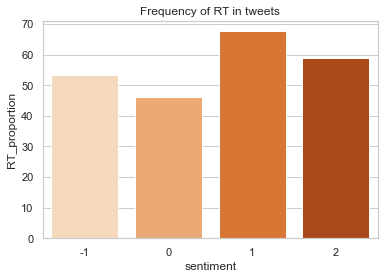

In [17]:
### Proportion of Re-tweets

RT_df = train_df[train_df['message'].str.contains("RT")]
RT_df = (RT_df.groupby('sentiment').count()/train_df.groupby('sentiment').count())*100
RT_df['RT_proportion'] = RT_df['message']
RT_df = RT_df[['RT_proportion']]

RT_df.reset_index(level=0, inplace=True)
RT_df

# Plotting 

sns.barplot(data=RT_df,
            y=RT_df['RT_proportion'],
            x=RT_df['sentiment'],
            palette='Oranges')

plt.title("Frequency of RT in tweets")
plt.show()

## 4.2 Balancing data

Imbalanced data raises a commmon issue in classification machine learning algorithm. 

When there are too few observations for a class, the model may not effectively learn the decision bhoundary.

Imbalance classes in the training data, thereby compromises the accuracy of the model. 

Here, we will explore several ways to circumvent the data imbalance.

### 4.2.1 Upsampling

Upsampling is the process of randomly and repetively sampling the minority class to reinforce its siganl.

This can be done by sampling the minority class with replacement.

<br>

From the sentiment count analysis, we have found that our data is imbalanced

The majority of the sentiment is based on class 1, which supports the existence of climate change (pro).

In [20]:
# Separating majority and minority classes

news_df  = train_df[train_df['sentiment'] == 2]
pro_df  = train_df[train_df['sentiment'] == 1]
neut_df = train_df[train_df['sentiment'] == 0]
anti_df = train_df[train_df['sentiment'] == -1]

print('Total News tweets: ', len(news_df), '\n'
        'Total Pro tweets: ', len(pro_df), '\n'
        'Total Neutral tweets: ', len(neut_df), '\n'
        'Total Anti tweets: ', len(anti_df))

Total News tweets:  3640 
Total Pro tweets:  8530 
Total Neutral tweets:  2353 
Total Anti tweets:  1296


As expected, the number of "Pro" climate change tweets outnumber other tweet classes.

We will use the number of class 1 tweets to resample the minority classes.

In [21]:
# Importing resampling module from sklearn
from sklearn.utils import resample

In [24]:
# Separating majority and minority classes

news_df  = train_df[train_df['sentiment'] == 2]
pro_df  = train_df[train_df['sentiment'] == 1]
neut_df = train_df[train_df['sentiment'] == 0]
anti_df = train_df[train_df['sentiment'] == -1]

print('Total News tweets: ', len(news_df), '\n'
        'Total Pro tweets: ', len(pro_df), '\n'
        'Total Neutral tweets: ', len(neut_df), '\n'
        'Total Anti tweets: ', len(anti_df))

# Importing resampling module from sklearn
from sklearn.utils import resample

# Upsampling the minority classes

news_df_up = resample(news_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

neut_df_up = resample(neut_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

anti_df_up = resample(anti_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

# Concatanate the majority class and the upsampled minority classes
upsampled_df = pd.concat([pro_df, news_df_up, neut_df_up, anti_df_up])


In [27]:
# Counting the upsampled classes
upsampled_df['sentiment'].value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

### 4.2.2 Downsampling

Downsampling is the opposite of upsampling, wherein the observations in the majority class

is randomly removed to avoid domination of the data.

The data is downsampled by being sampled **without** replacement

<br>

The 'Anti" climate change tweet is the least abundant class in our data with only 1296 observations.

In [29]:
# Downsampling the majority classes

news_df_down = resample(news_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

neut_df_down = resample(neut_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

pro_df_down = resample(pro_df,
                      replace = False,
                      n_samples = 1296,
                      random_state = 1)

# Concatanate the minorty class and the downsampled majority classes
downsampled_df = pd.concat([anti_df, news_df_down, neut_df_down, pro_df_down])


In [30]:
# Counting the downsampled classes
downsampled_df['sentiment'].value_counts()

 0    1296
 1    1296
 2    1296
-1    1296
Name: sentiment, dtype: int64

### 4.2.3 Synthetic Minority Oversampling Technique (SMOTE)

Upsampling resolves the data imbalance by sampling the existing observation with replacement.

However, this does not provide any additional information to the model.

<br>

SMOTE works by synthesising new observations from the existing examples in the minority classes.

In bried, a random observations is chosen from the minority class, then k (usually 5) of the nearest

neighbours are found and one is randomly chosen. The synthetic observation is created at a randomly

selected point between the two existing examples in the feature space. As a result, SMOTE not only

increase the number of minority classes but also provide somewhat informative addtion for the model.

# 5. Data Preprocessing

In [18]:
def clean_twt(col):

    # Emoji to Text
    col = emoji.demojize(col, delimiters=("", "")) 

    # Lower case-ing
    col = col.lower()

    # Replace urls
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    web = 'url'
    col = re.sub(url, web, col)
    
    # Removing Mention
    mentions = r'@[\w]*'
    rep = ''
    #col = re.sub(mentions, rep, col)

    # Removing Hasgtags
    hashtags = r'#[\w]*'
    rep = ''
    #col = re.sub(hashtags, rep, col)

    # Remove Puncuation
    col = ''.join(i for i in col if i not in punctuation)
    
    # Removing non-alphabets
    col = re.sub('[^a-z]', ' ',col)

    # Tokenisation & Lemmatisation
    lemmatizer = WordNetLemmatizer()
    col = [lemmatizer.lemmatize(token) for token in col.split(' ')]
    col = [lemmatizer.lemmatize(token, 'v') for token in col]
    col = ' '.join(col)
   
    return col

In [19]:
#Apply data cleaning function to data
train_df['clean_message'] = train_df['message'].map(clean_twt)
test_df['clean_message'] = test_df['message'].map(clean_twt)

In [20]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  
0  polyscimajor epa chief doesnt think carbon dio...  
1  it not like we lack evidence of anthropogenic ...  
2  rt rawstory researcher say we have three year ...  
3  todayinmaker wire       wa a pivotal year in t...  
4  rt soynoviodetodas it      and a racist sexist...

### 5.2. Tokenisation

In [21]:
#We first initialise our tokenizer
tokeniser = TreebankWordTokenizer()
train_df['tokens'] =train_df['clean_message'].apply(tokeniser.tokenize)

In [22]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief doesnt think carbon dio...   
1  it not like we lack evidence of anthropogenic ...   
2  rt rawstory researcher say we have three year ...   
3  todayinmaker wire       wa a pivotal year in t...   
4  rt soynoviodetodas it      and a racist sexist...   

                                              tokens  
0  [polyscimajor, epa, chief, doesnt, think, carb...  
1  [it, not, like, we, lack, evidence, of, anthro...  
2  [rt, rawstory, researcher, say, we, have, thre...  
3  [todayinmaker, wire, wa, a, pivotal, year, in,...  
4  [rt, soynoviodetodas, it, and, a, racist, sexi...

### 5.3. Retrieving Base Forms

Retrieving Base Forms involves taking words and generating their root form. One should always be caref There are 2 primary techniques for text normalisation namely:
* Stemming
* Lemmatization

N.B. Should exercise caution because many times the context of a word is lost when itis converted to its base form.


We will be using Lemmatization although it's a bit slower than stemming

In [23]:
lemmatizer = WordNetLemmatizer()

train_df['tokens'] = train_df['tokens'].apply(lambda y: [lemmatizer.lemmatize(i) for i in y])

In [24]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief doesnt think carbon dio...   
1  it not like we lack evidence of anthropogenic ...   
2  rt rawstory researcher say we have three year ...   
3  todayinmaker wire       wa a pivotal year in t...   
4  rt soynoviodetodas it      and a racist sexist...   

                                              tokens  
0  [polyscimajor, epa, chief, doesnt, think, carb...  
1  [it, not, like, we, lack, evidence, of, anthro...  
2  [rt, rawstory, researcher, say, we, have, thre...  
3  [todayinmaker, wire, wa, a, pivotal, year, in,...  
4  [rt, soynoviodetodas, it, and, a, racist, sexi...

### 5.4. Stop Words Removal

In [25]:
train_df['tokens'] = train_df['tokens'].apply(lambda z: [i for i in z if i not in stopwords.words('english')])

In [26]:
# clean_message without stop words
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief doesnt think carbon dio...   
1  it not like we lack evidence of anthropogenic ...   
2  rt rawstory researcher say we have three year ...   
3  todayinmaker wire       wa a pivotal year in t...   
4  rt soynoviodetodas it      and a racist sexist...   

                                              tokens  
0  [polyscimajor, epa, chief, doesnt, think, carb...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [rt, rawstory, researcher, say, three, year, a...  
3  [todayinmaker, wire, wa, pivotal, year, war, c...  
4  [rt, soynoviodetodas, racist, sexist, climate,...

## 6. Exploratory Data Analysis

Now let's us study the distribution of the length of the words
* First we obtained a list containing all the words
* We obtained the lenth of each word and counted the number of times the word appears in our list
* we grouped frequencies by lenght and summed them up.

In [27]:
word_list =  train_df['tokens'].values
all_words_ls=[word_list[i][j] for i in range(len(word_list)) for j in range(len(word_list[i]))]
word_length_each =pd.DataFrame([[len(i),all_words_ls.count(i)] for i in set(all_words_ls)], 
                               columns = ['word_length','frequency'])

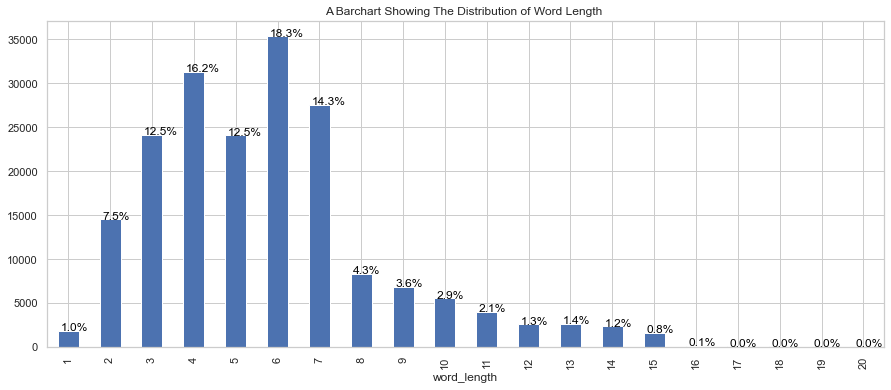

In [28]:
word_length_freq = word_length_each.groupby('word_length')['frequency'].sum().head(20).plot(kind ='bar', 
                                                                                           title = "A Barchart Showing The Distribution of Word Length ", 
                                                                                           figsize = (15,6))
n_obs = [i.get_height() for i in word_length_freq.patches]
total = sum(n_obs)

for i in word_length_freq.patches:
    # get_x pulls left or right; get_height pushes up or down
    word_length_freq.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

The lengths of the words ranged from 1-70, to obtain a better visualisation we limited the domain to words of lengths 1-2The length of the words appears to be positively skewed. We can expect the data to contain outliers to the right of the distribution. Most words lengths (78.4%) lies between 3-8,with the peak being 7.

We investigated words with lengths greater than 20 and the outcome is displayed below

In [29]:
greater_than_20 = [i for i in all_words_ls if len(i)>20]
print(greater_than_20)

['environmentlondongovuk', 'warmingfacewithtearsofjoyfireglobeshowingamericassnowflake', 'facewithrollingeyesfacewithrollingeyes', 'facewithtearsofjoyfacewithtearsofjoy', 'technologysehipnotize', 'expressionlessfacesnowflake', 'probablywonthappenbutwhoreallyknows', 'yearsflushedfaceflushedfaceflushedface', 'yafacewithrollingeyesfacewithrollingeyes', 'umbrellawithraindrops', 'sustainabledevelopment', 'thinkingfacethinkingfacethinkingface', 'unamusedfacethumbsdownlightskintoneglobeshowingeuropeafrica', 'winkingfacewithtonguefoldedhandslightskintonesmilingfacewithhalo', 'ourwetlandsoursafetywetlands', 'clappinghandsmediumskintone', 'clappinghandsmediumskintone', 'clappinghandsmediumskintone', 'globeshowingeuropeafrica', 'unitedstatesreminderunitedstates', 'hillarypersonraisinghandmediumlightskintone', 'changeglobeshowingamericas', 'prochoicepregnantwomanmediumskintone', 'corporateaccountability', 'linefacewithtearsofjoy', 'changeglobeshowingeuropeafrica', 'stepstoreverseclimatechange', 'h

From the above,we saw the words are nonsensical (mashup of words). And since they form small part of our sample we decided to remove them.

In [30]:
train_df['tokens'] = train_df['tokens'].apply(lambda x : [i for i in x if i not in greater_than_20])

Making the 'clean_message' column to match the content in tokens

In [31]:
train_df['clean_message'] = train_df['tokens'].apply(lambda a: ' '.join([i for i in a]))

In order to identify the most common words tweeted, we plotted the wordcloud of all the words in our clean corpus. A bigger font implies higher frequency.

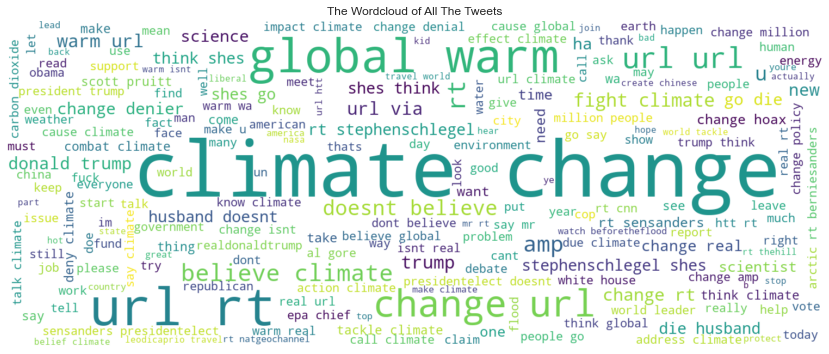

In [32]:
all_words = ' '.join([text for text in train_df['clean_message']])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(all_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of All The Tweets')
plt.show()

From The above we can see that our data still has a bit of noise. We might need to remove words of length less than 3.



We then obtained the most occurring words tweets that do not believe in man-made climate change

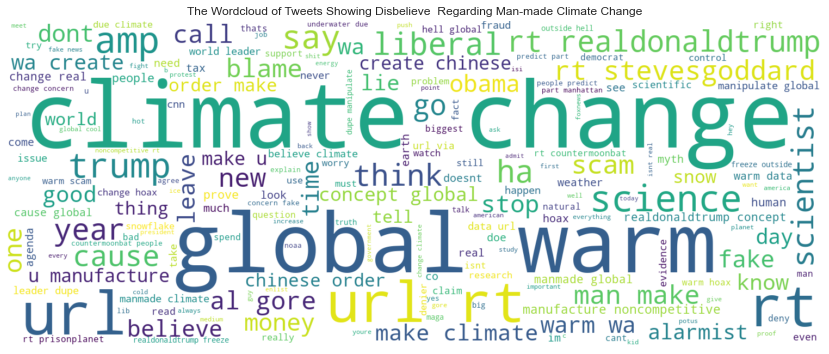

In [33]:
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == -1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neg_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Disbelieve  Regarding Man-made Climate Change')
plt.show()

We obtained the most frequently used words to tweets that displayed belief in man-made climate change

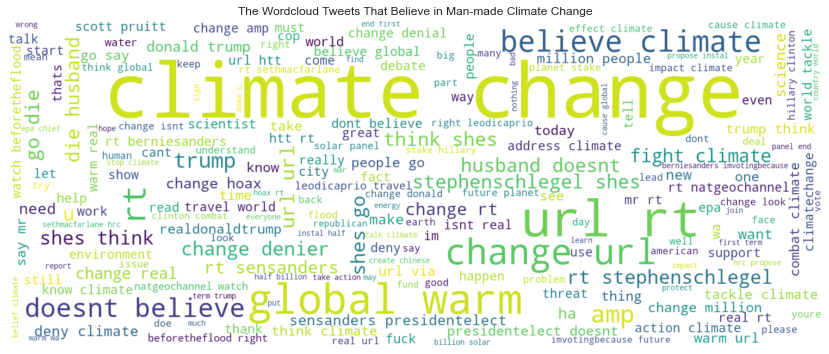

In [34]:
pro_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 1]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(pro_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Believe in Man-made Climate Change')

plt.show()

Neutral

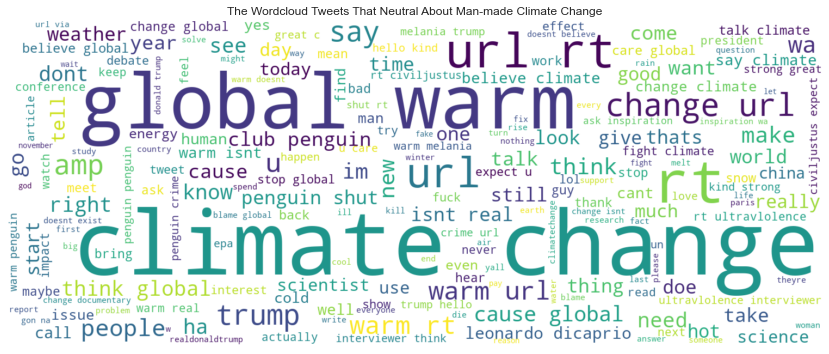

In [35]:
neutral_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 0]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(neutral_words)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud Tweets That Neutral About Man-made Climate Change')
plt.show()

Factual News about man-made cimate change

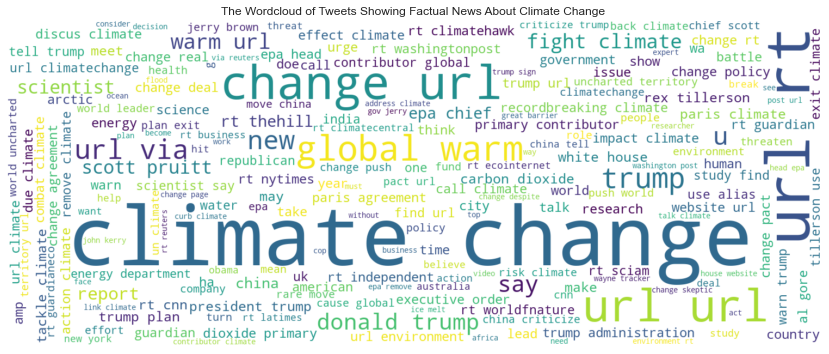

In [36]:
news = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(news)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Wordcloud of Tweets Showing Factual News About Climate Change ')
plt.show()

Our analysis above indicated that we might need to remove words with length 1 and 2. Words such as rt  and $\tilde{a}$. So we limited our analysis to these lengths to see the most frequenty occuring words.


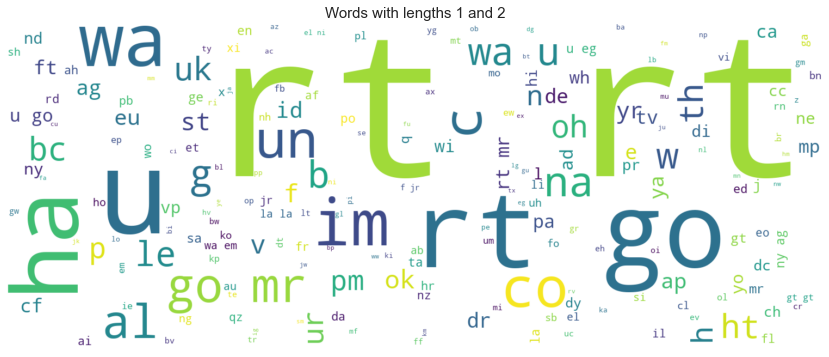

In [37]:
len_12 = ' '.join([i for i in all_words_ls if len(i)<3])
neg_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment'] == 2]])

wordcloud = WordCloud(width=1500, height=600,  background_color='white').generate(len_12)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words with lengths 1 and 2', fontsize=15)
plt.axis('off')
plt.show()

The words above were regarded as noise. We decided to remove all the words with a length less than 3.

In [38]:
less_than_3 = [i for i in all_words_ls if len(i)<3]

train_df['tokens'] = train_df['tokens'].apply(lambda x : [i for i in x if i not in less_than_3])

In [39]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief doesnt think carbon dio...   
1       like lack evidence anthropogenic global warm   
2  rt rawstory researcher say three year act clim...   
3  todayinmaker wire wa pivotal year war climate ...   
4  rt soynoviodetodas racist sexist climate chang...   

                                              tokens  
0  [polyscimajor, epa, chief, doesnt, think, carb...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [rawstory, researcher, say, three, year, act, ...  
3  [todayinmaker, wire, pivotal, year, war, clima...  
4  [soynoviodetodas, racist, sexist, climate, cha...

## Tweet length Distribution



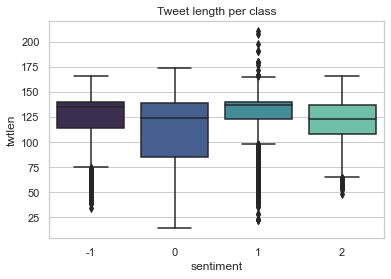

In [40]:
# Crate a new column 'twtlen' which determnines the length of the tweets
train_df['twtlen'] = train_df['message'].str.len()

# Plotting Twt length distribution
sns.boxplot(data = train_df,
            y=train_df['twtlen'], 
            x=train_df['sentiment'],
            palette='mako')

plt.title("Tweet length per class")
plt.show()

## Top Hashtags


Hashtag is a useful feature on Twitter which allows the user to discern a particular topic of interest. 

We previously created 4 new data frames namely pro_has, anti_has, neutral_has, and news_has, each dataframe 

contains the list of top 10 Hashtags and the frequency (count) of hashtag found in the twt messages.

<br>

It may be insightful to see how and what hashtags are used by different sentiment classes.

The hashtag frequency will allow us to understand what topic is addressed and shared in each class

In [41]:
pro_has.head()

hashtag  count
19          climate    187
24   BeforeTheFlood    129
68    climatechange     94
13  ImVotingBecause     62
4             COP22     59

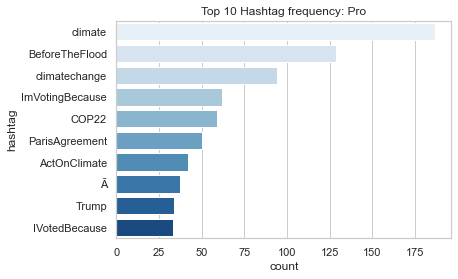

In [42]:
### Pro-believer in climate change

sns.barplot(data=pro_has,
            y=pro_has['hashtag'],
            x=pro_has['count'],
            palette='Blues')

plt.title("Top 10 Hashtag frequency: Pro")
plt.show()

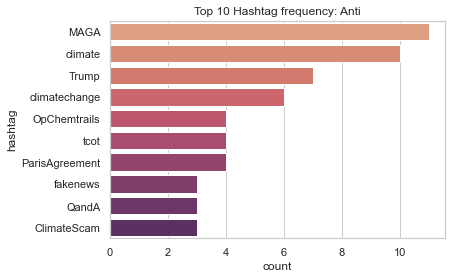

In [43]:
### Anti-believer 

sns.barplot(data=anti_has,
            y=anti_has['hashtag'],
            x=anti_has['count'],
            palette='flare')

plt.title("Top 10 Hashtag frequency: Anti")
plt.show()

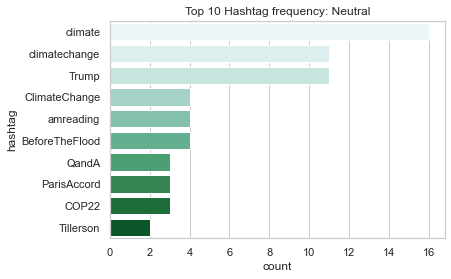

In [44]:
### Neutrals

sns.barplot(data=neutral_has,
            y=neutral_has['hashtag'],
            x=neutral_has['count'],
            palette='BuGn')

plt.title("Top 10 Hashtag frequency: Neutral")
plt.show()

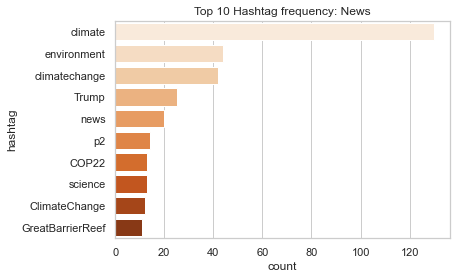

In [45]:
### News

sns.barplot(data=news_has,
            y=news_has['hashtag'],
            x=news_has['count'],
            palette='Oranges')

plt.title("Top 10 Hashtag frequency: News")
plt.show()

## Top mentions

Similar to Hashtags, mention (@) is a Twitter function that allows the user to tag/summon another user in a tweet.

Four new data frames namely pro_men, anti_men, neutral_men, and news_men were created earlier in the notebook.

Each notebook contains the list of top 10 Mentions and the frequency (count) of the hashtag found in the twt messages.

<br>

It may provide better understaning of the person/entity that mentioned frequently by each class.

In [46]:
pro_men.head()

Mention  count
6   StephenSchlegel    307
14       SenSanders    245
50  realDonaldTrump    164
40      LeoDiCaprio    129
22    BernieSanders    123

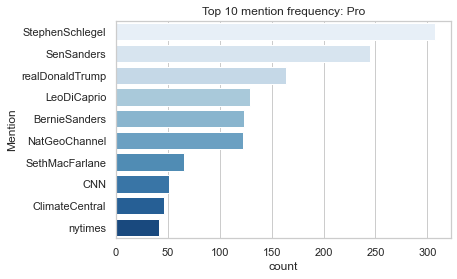

In [47]:
### Pro-believer in climate change

sns.barplot(data=pro_men,
            y=pro_men['Mention'],
            x=pro_men['count'],
            palette='Blues')

plt.title("Top 10 mention frequency: Pro")
plt.show()

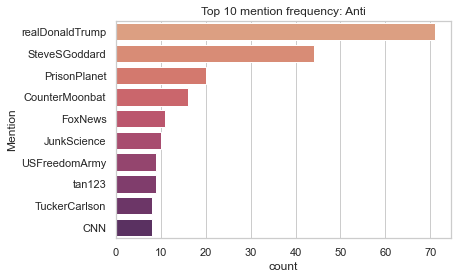

In [48]:
### Anti-believer 

sns.barplot(data=anti_men,
            y=anti_men['Mention'],
            x=anti_men['count'],
            palette='flare')

plt.title("Top 10 mention frequency: Anti")
plt.show()

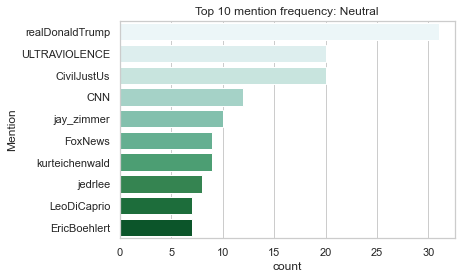

In [49]:
### Neutrals

sns.barplot(data=neutral_men,
            y=neutral_men['Mention'],
            x=neutral_men['count'],
            palette='BuGn')

plt.title("Top 10 mention frequency: Neutral")
plt.show()

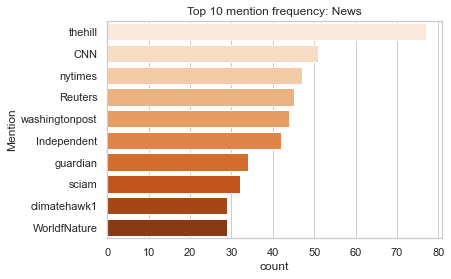

In [50]:
### News

sns.barplot(data=news_men,
            y=news_men['Mention'],
            x=news_men['count'],
            palette='Oranges')

plt.title("Top 10 mention frequency: News")
plt.show()

# 8. Model Building

In [51]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief doesnt think carbon dio...   
1       like lack evidence anthropogenic global warm   
2  rt rawstory researcher say three year act clim...   
3  todayinmaker wire wa pivotal year war climate ...   
4  rt soynoviodetodas racist sexist climate chang...   

                                              tokens  twtlen  
0  [polyscimajor, epa, chief, doesnt, think, carb...     140  
1  [like, lack, evidence, anthropogenic, global, ...      62  
2  [rawstory, researcher, say, three, year, act, ...     140  
3  [todayinmaker, wire, pivotal, year, war, clima...      99  
4  [soynoviodetodas, racist, sexist, climate, cha...     122

In [52]:
test_df.head()

message  tweetid  \
0  Europe will now be looking to China to make su...   169760   
1  Combine this with the polling of staffers re c...    35326   
2  The scary, unimpeachable evidence that climate...   224985   
3  @Karoli @morgfair @OsborneInk @dailykos \r\nPu...   476263   
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928   

                                       clean_message  
0  europe will now be look to china to make sure ...  
1  combine this with the poll of staffer re clima...  
2  the scary unimpeachable evidence that climate ...  
3  karoli morgfair osborneink dailykos   putin ge...  
4  rt fakewillmoore female orgasm cause global wa...

## 8.1 Train-Test Split

In [53]:
X  =  train_df['clean_message']
y = train_df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 26, shuffle = True, stratify = y)

## 8.2 Individual Models

In [54]:
# GridSearch Result: {'clf__C': 10, 'clf__max_iter': 1000, 'tfidf__max_df': 0.9, 'tfidf__min_df': 0}

lr = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', LogisticRegression())])

#Logistic Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print('Model: Logistic Regression')
print(metrics.classification_report(y_test, y_pred_lr))

Model: Logistic Regression
              precision    recall  f1-score   support

          -1       0.90      0.34      0.49       130
           0       0.70      0.32      0.44       235
           1       0.74      0.92      0.82       853
           2       0.75      0.75      0.75       364

    accuracy                           0.75      1582
   macro avg       0.77      0.58      0.63      1582
weighted avg       0.75      0.75      0.72      1582

D:\EXPLORE\Software\Software\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# GridSearch Result: {'clf__C': 0.1, 'clf__max_iter': 100, 'tfidf__max_df': 0.8, 'tfidf__max_features': 10000, 'tfidf__min_df': 0}
lsvc = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                           ngram_range=(1,2))), 
                 ('clf', LinearSVC())])

#Linear Support Vector Classifier
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)

print('Model: Linear SVM')
print(metrics.classification_report(y_test, y_pred_lsvc))

Model: Linear SVM
              precision    recall  f1-score   support

          -1       0.79      0.51      0.62       130
           0       0.73      0.40      0.52       235
           1       0.77      0.90      0.83       853
           2       0.75      0.76      0.76       364

    accuracy                           0.76      1582
   macro avg       0.76      0.64      0.68      1582
weighted avg       0.76      0.76      0.75      1582



In [56]:
dt = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.9,
                                            ngram_range=(1,2))), 
               ('clf', DecisionTreeClassifier())])

#Decision Tree Classifer
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print('Model: Decision Tree Classifier')
print(metrics.classification_report(y_test, y_pred_dt))

Model: Decision Tree Classifier
              precision    recall  f1-score   support

          -1       0.50      0.27      0.35       130
           0       0.33      0.50      0.39       235
           1       0.70      0.68      0.69       853
           2       0.62      0.58      0.60       364

    accuracy                           0.59      1582
   macro avg       0.54      0.50      0.51      1582
weighted avg       0.61      0.59      0.60      1582



In [57]:
rf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', RandomForestClassifier())])

#Random Forest Classifier
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Model: Random Forest Classifier')
print(metrics.classification_report(y_test, y_pred_rf))

COMET ERROR: Failed to extract parameters from estimator
Model: Random Forest Classifier
              precision    recall  f1-score   support

          -1       0.88      0.22      0.35       130
           0       0.54      0.44      0.49       235
           1       0.71      0.88      0.79       853
           2       0.79      0.65      0.72       364

    accuracy                           0.71      1582
   macro avg       0.73      0.55      0.58      1582
weighted avg       0.72      0.71      0.69      1582



In [58]:
knn = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))),  
                ('clf', KNeighborsClassifier())])

# K-Nearest Neighbors Classifier
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('Model: KNN Classifier')
print(metrics.classification_report(y_test, y_pred_knn))

Model: KNN Classifier
              precision    recall  f1-score   support

          -1       0.52      0.42      0.47       130
           0       0.45      0.42      0.43       235
           1       0.74      0.75      0.74       853
           2       0.60      0.65      0.62       364

    accuracy                           0.65      1582
   macro avg       0.58      0.56      0.57      1582
weighted avg       0.65      0.65      0.65      1582



In [59]:
mnnb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', MultinomialNB())])

# Multinomial NB Classifier
mnnb.fit(X_train, y_train)
y_pred_mnnb = mnnb.predict(X_test)

print('Model: Multinomial NB Classifier')
print(metrics.classification_report(y_test, y_pred_mnnb))

Model: Multinomial NB Classifier
              precision    recall  f1-score   support

          -1       1.00      0.06      0.12       130
           0       1.00      0.04      0.07       235
           1       0.61      0.99      0.75       853
           2       0.91      0.43      0.58       364

    accuracy                           0.64      1582
   macro avg       0.88      0.38      0.38      1582
weighted avg       0.77      0.64      0.56      1582



In [60]:
sgd = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', SGDClassifier())])

# SGD Classifier
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

print('Model: SGD Classifier')
print(metrics.classification_report(y_test, y_pred_sgd))

Model: SGD Classifier
              precision    recall  f1-score   support

          -1       0.85      0.44      0.58       130
           0       0.76      0.31      0.44       235
           1       0.75      0.91      0.83       853
           2       0.73      0.77      0.75       364

    accuracy                           0.75      1582
   macro avg       0.77      0.61      0.65      1582
weighted avg       0.76      0.75      0.73      1582



In [61]:
ada = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', AdaBoostClassifier())])

# Adaboost Classifier
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)


print('Model: Adaboost Classifier')
print(metrics.classification_report(y_test, y_pred_ada))

COMET ERROR: Failed to extract parameters from estimator
Model: Adaboost Classifier
              precision    recall  f1-score   support

          -1       0.72      0.32      0.44       130
           0       0.54      0.19      0.28       235
           1       0.63      0.88      0.74       853
           2       0.66      0.45      0.54       364

    accuracy                           0.63      1582
   macro avg       0.64      0.46      0.50      1582
weighted avg       0.63      0.63      0.60      1582



In [62]:
grd = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', GradientBoostingClassifier())])

# Gradient Boost Classifier
grd.fit(X_train, y_train)
y_pred_grd = grd.predict(X_test)

print('Model: Gradient Boost Classifier')
print(metrics.classification_report(y_test, y_pred_grd))

COMET ERROR: Failed to extract parameters from estimator
Model: Gradient Boost Classifier
              precision    recall  f1-score   support

          -1       0.95      0.28      0.43       130
           0       0.57      0.33      0.42       235
           1       0.67      0.88      0.76       853
           2       0.69      0.54      0.61       364

    accuracy                           0.67      1582
   macro avg       0.72      0.51      0.55      1582
weighted avg       0.68      0.67      0.65      1582



# Top 3 Models

### Weighted F1 score

Logistic Regression = 0.72 

Linear SVC = 0.75

SGD  Classifier = 0.73 

# GridSearch

In [177]:
X  =  train_df['clean_message']
y = train_df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 26, shuffle = True, stratify = y)

## Logistic Regression

In [20]:
lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [33]:
param_grid = {'clf__max_iter': [100,1000,3000],
                'clf__C': [0.1, 0.5, 1, 10, 100]}

grid_lr = GridSearchCV(lr, param_grid, scoring='f1_weighted', verbose=10)

grid_lr.fit(X_train, y_train)
grid_lr.best_params_

ax_iter=1000;, score=0.551 total time=   3.5s
[CV 1/5; 3/15] START clf__C=0.1, clf__max_iter=3000.............................
[CV 1/5; 3/15] END clf__C=0.1, clf__max_iter=3000;, score=0.558 total time=   3.6s
[CV 2/5; 3/15] START clf__C=0.1, clf__max_iter=3000.............................
[CV 2/5; 3/15] END clf__C=0.1, clf__max_iter=3000;, score=0.560 total time=   3.4s
[CV 3/5; 3/15] START clf__C=0.1, clf__max_iter=3000.............................
[CV 3/5; 3/15] END clf__C=0.1, clf__max_iter=3000;, score=0.544 total time=   3.7s
[CV 4/5; 3/15] START clf__C=0.1, clf__max_iter=3000.............................
[CV 4/5; 3/15] END clf__C=0.1, clf__max_iter=3000;, score=0.555 total time=   3.6s
[CV 5/5; 3/15] START clf__C=0.1, clf__max_iter=3000.............................
[CV 5/5; 3/15] END clf__C=0.1, clf__max_iter=3000;, score=0.551 total time=   3.6s
[CV 1/5; 4/15] START clf__C=0.5, clf__max_iter=100..............................
D:\EXPLORE\Software\Software\lib\site-packages\sklear

{'clf__C': 100, 'clf__max_iter': 100}

## Linear SVC

In [46]:
lsvc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__loss', 'clf__max_iter', 'clf__multi_class', 'clf__penalty', 'clf__random_state', 'clf__tol', 'clf__verbose'])

In [51]:
param_grid = {'clf__max_iter': [100,1000,3000],
                'clf__C': [0.1, 0.5, 1, 10, 100]}

grid_lsvc = GridSearchCV(lsvc, param_grid, scoring='f1_weighted', verbose=10)

grid_lsvc.fit(X_train, y_train)
grid_lsvc.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START clf__C=0.1, clf__max_iter=100..............................
[CV 1/5; 1/15] END clf__C=0.1, clf__max_iter=100;, score=0.713 total time=   0.9s
[CV 2/5; 1/15] START clf__C=0.1, clf__max_iter=100..............................
[CV 2/5; 1/15] END clf__C=0.1, clf__max_iter=100;, score=0.721 total time=   0.9s
[CV 3/5; 1/15] START clf__C=0.1, clf__max_iter=100..............................
[CV 3/5; 1/15] END clf__C=0.1, clf__max_iter=100;, score=0.724 total time=   1.0s
[CV 4/5; 1/15] START clf__C=0.1, clf__max_iter=100..............................
[CV 4/5; 1/15] END clf__C=0.1, clf__max_iter=100;, score=0.724 total time=   1.2s
[CV 5/5; 1/15] START clf__C=0.1, clf__max_iter=100..............................
[CV 5/5; 1/15] END clf__C=0.1, clf__max_iter=100;, score=0.728 total time=   1.2s
[CV 1/5; 2/15] START clf__C=0.1, clf__max_iter=1000.............................
[CV 1/5; 2/15] END clf__C=0.1, clf__max_ite

{'clf__C': 0.5, 'clf__max_iter': 100}

## SGD Classifier

In [53]:
sgd.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__alpha', 'clf__average', 'clf__class_weight', 'clf__early_stopping', 'clf__epsilon', 'clf__eta0', 'clf__fit_intercept', 'clf__l1_ratio', 'clf__learning_rate', 'clf__loss', 'clf__max_iter', 'clf__n_iter_no_change', 'clf__n_jobs', 'clf__penalty', 'clf__power_t', 'clf__random_state', 'clf__shuffle', 'clf__tol', 'clf__validation_fraction', 'clf__verbose', 'clf__warm_start'])

In [57]:
param_grid = {'clf__max_iter': [1000,5000,10000],
                'clf__alpha': [0.1, 0.01, 0.001, 0.0001]}

grid_sgd = GridSearchCV(sgd, param_grid, scoring='f1_weighted', verbose=10)

grid_sgd.fit(X_train, y_train)
grid_sgd.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START clf__alpha=0.1, clf__max_iter=5000..........................
[CV 1/5; 1/8] END clf__alpha=0.1, clf__max_iter=5000;, score=0.378 total time=   1.4s
[CV 2/5; 1/8] START clf__alpha=0.1, clf__max_iter=5000..........................
[CV 2/5; 1/8] END clf__alpha=0.1, clf__max_iter=5000;, score=0.378 total time=   1.0s
[CV 3/5; 1/8] START clf__alpha=0.1, clf__max_iter=5000..........................
[CV 3/5; 1/8] END clf__alpha=0.1, clf__max_iter=5000;, score=0.378 total time=   0.9s
[CV 4/5; 1/8] START clf__alpha=0.1, clf__max_iter=5000..........................
[CV 4/5; 1/8] END clf__alpha=0.1, clf__max_iter=5000;, score=0.378 total time=   0.8s
[CV 5/5; 1/8] START clf__alpha=0.1, clf__max_iter=5000..........................
[CV 5/5; 1/8] END clf__alpha=0.1, clf__max_iter=5000;, score=0.378 total time=   0.8s
[CV 1/5; 2/8] START clf__alpha=0.1, clf__max_iter=10000.........................
[CV 1/5; 2/8] END clf__a

{'clf__alpha': 0.0001, 'clf__max_iter': 10000}

# Model Performance with Hyperparameter Tuning

In [63]:
# GridSearch Result: {'clf__C': 10, 'clf__max_iter': 1000, 'tfidf__max_df': 0.9, 'tfidf__min_df': 0}

lr = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', LogisticRegression(C=10, 
                                            max_iter=1000))])

#Logistic Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print('Model: Logistic Regression')
print(metrics.classification_report(y_test, y_pred_lr))

Model: Logistic Regression
              precision    recall  f1-score   support

          -1       0.80      0.51      0.62       130
           0       0.72      0.39      0.51       235
           1       0.77      0.91      0.83       853
           2       0.76      0.76      0.76       364

    accuracy                           0.77      1582
   macro avg       0.77      0.64      0.68      1582
weighted avg       0.76      0.77      0.75      1582



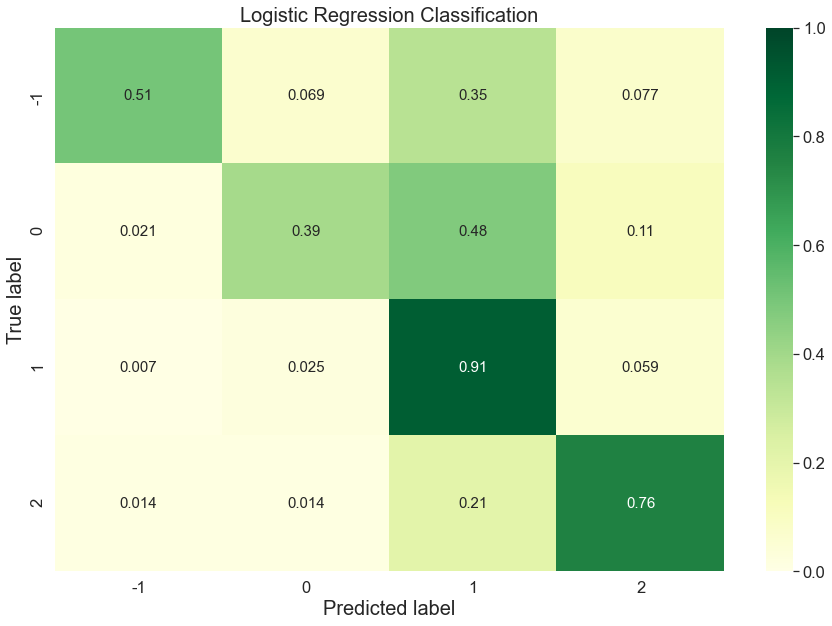

In [67]:
sns.set(font_scale=1.5)

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_norm_lr = cm_lr / cm_lr.sum(axis=1).reshape(-1,1)
plt.figure(figsize=(15, 10))
sns.heatmap(cm_norm_lr, 
            cmap="YlGn", 
            xticklabels=lr.classes_, 
            yticklabels=lr.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':15})

# Adding headings and lables

plt.title('Logistic Regression Classification', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()


In [82]:
X_real = test_df['clean_message']

y_real_lr = lr.predict(X_real)

test_df['sentiment'] = y_real_lr

test_df[['tweetid', 'sentiment']].to_csv('lr2.csv', index = False)

In [71]:
# GridSearch Result: {'clf__C': 0.1, 'clf__max_iter': 100, 'tfidf__max_df': 0.8, 'tfidf__max_features': 10000, 'tfidf__min_df': 0}

lsvc = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                                max_features=10000,
                                           ngram_range=(1,2))), 
                 ('clf', LinearSVC(C=0.1, max_iter=100, class_weight='balanced'))])

#Linear Support Vector Classifier
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)

print('Model: Linear SVM')
print(metrics.classification_report(y_test, y_pred_lsvc))

Model: Linear SVM
              precision    recall  f1-score   support

          -1       0.61      0.59      0.60       130
           0       0.52      0.49      0.50       235
           1       0.83      0.79      0.81       853
           2       0.70      0.80      0.75       364

    accuracy                           0.73      1582
   macro avg       0.66      0.67      0.67      1582
weighted avg       0.74      0.73      0.73      1582



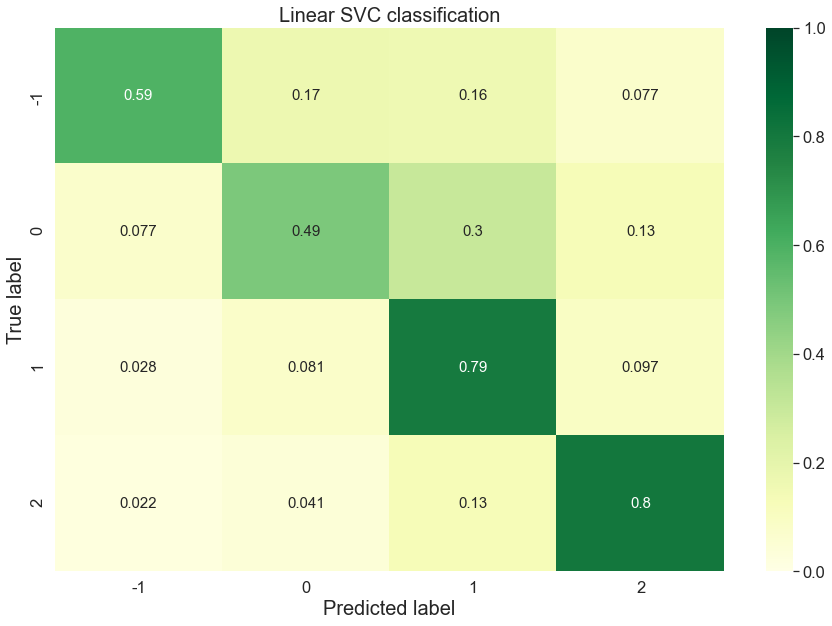

In [72]:
sns.set(font_scale=1.5)

cm_lsvc = confusion_matrix(y_test, y_pred_lsvc)
cm_norm_lsvc = cm_lsvc / cm_lsvc.sum(axis=1).reshape(-1,1)
plt.figure(figsize=(15, 10))
sns.heatmap(cm_norm_lsvc, 
            cmap="YlGn", 
            xticklabels=lsvc.classes_, 
            yticklabels=lsvc.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':15})

# Adding headings and lables

plt.title('Linear SVC classification', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()


In [50]:
X_real = test_df['clean_message']

y_real_lsvc = lsvc.predict(X_real)

test_df['sentiment'] = y_real_lsvc

test_df[['tweetid', 'sentiment']].to_csv('lsvc.csv', index = False)

In [73]:
# Gridsearch Result: {'clf__alpha': 0.0001, 'clf__max_iter': 10000}

sgd = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', SGDClassifier(alpha=0.0001,
                                        max_iter=10000))])

# SGD Classifier
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

print('Model: SGD Classifier')
print(metrics.classification_report(y_test, y_pred_sgd))

Model: SGD Classifier
              precision    recall  f1-score   support

          -1       0.86      0.44      0.58       130
           0       0.76      0.31      0.44       235
           1       0.75      0.92      0.83       853
           2       0.74      0.77      0.76       364

    accuracy                           0.75      1582
   macro avg       0.78      0.61      0.65      1582
weighted avg       0.76      0.75      0.73      1582



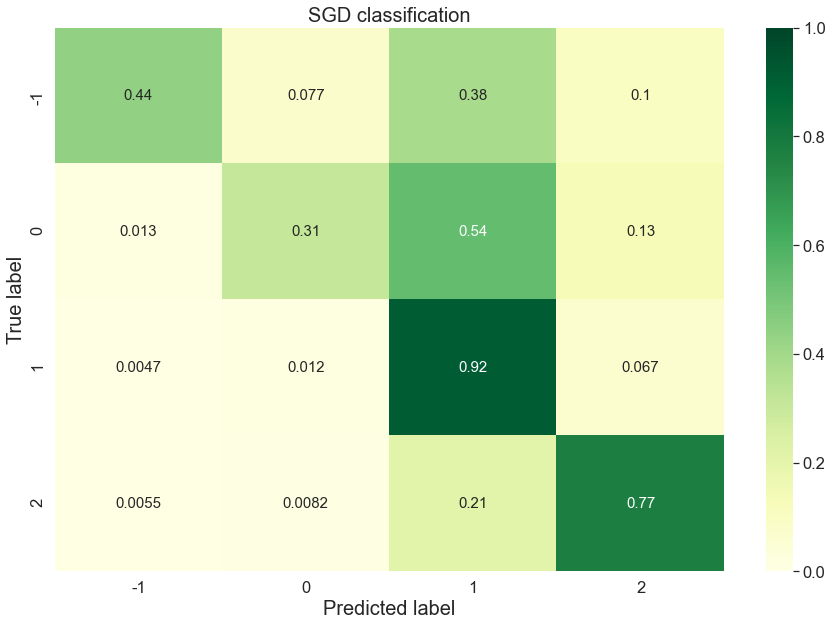

In [74]:
sns.set(font_scale=1.5)

cm_sgd = confusion_matrix(y_test, y_pred_sgd)
cm_norm_sgd = cm_sgd / cm_sgd.sum(axis=1).reshape(-1,1)
plt.figure(figsize=(15, 10))
sns.heatmap(cm_norm_sgd, 
            cmap="YlGn", 
            xticklabels=sgd.classes_, 
            yticklabels=sgd.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':15})

# Adding headings and lables

plt.title('SGD classification', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()


# Stacking

In [75]:
from sklearn.ensemble import StackingClassifier

# GridSearch Result: {'clf__C': 10, 'clf__max_iter': 1000, 'tfidf__max_df': 0.9, 'tfidf__min_df': 0}
# GridSearch Result: {'clf__C': 0.1, 'clf__max_iter': 100, 'tfidf__max_df': 0.8, 'tfidf__max_features': 10000, 'tfidf__min_df': 0}
# Gridsearch Result: {'clf__alpha': 0.0001, 'clf__max_iter': 10000}

# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(C=10, max_iter=1000)))
level0.append(('lsvc', LinearSVC(C=0.5, max_iter=100)))
level0.append(('sgd', SGDClassifier(alpha=0.0001, max_iter=10000)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)


In [76]:
stack = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', model)])

# SGD Classifier
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

print('Model: SGD Classifier')
print(metrics.classification_report(y_test, y_pred_stack))

Model: SGD Classifier
              precision    recall  f1-score   support

          -1       0.69      0.63      0.66       130
           0       0.65      0.43      0.52       235
           1       0.80      0.88      0.84       853
           2       0.76      0.79      0.78       364

    accuracy                           0.77      1582
   macro avg       0.73      0.68      0.70      1582
weighted avg       0.76      0.77      0.76      1582

D:\EXPLORE\Software\Software\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


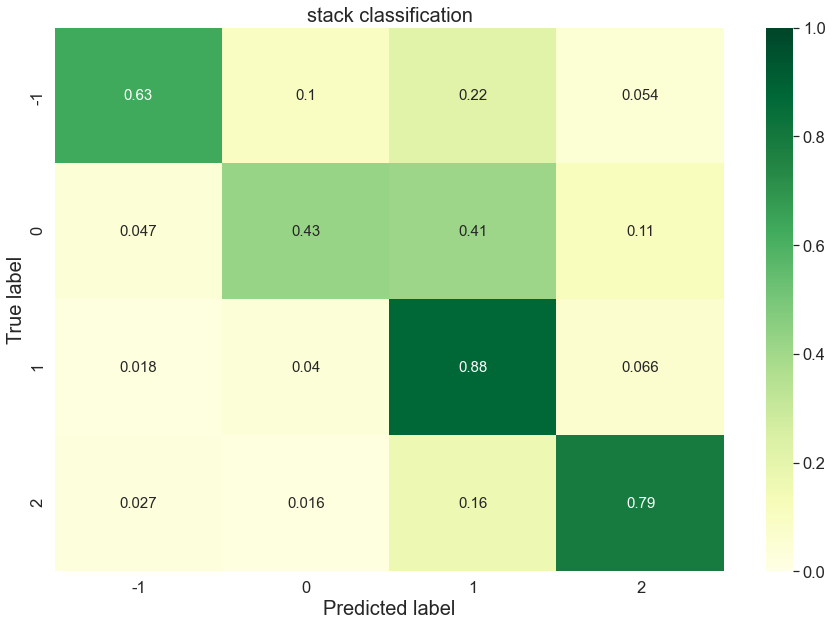

In [77]:
sns.set(font_scale=1.5)

cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_norm_stack = cm_stack / cm_stack.sum(axis=1).reshape(-1,1)
plt.figure(figsize=(15, 10))
sns.heatmap(cm_norm_stack, 
            cmap="YlGn", 
            xticklabels=stack.classes_, 
            yticklabels=stack.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':15})

# Adding headings and lables

plt.title('stack classification', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()


In [87]:
X_real = test_df['clean_message']

y_real_stack = stack.predict(X_real)

test_df['sentiment'] = y_real_stack

test_df[['tweetid', 'sentiment']].to_csv('stack2.csv', index = False)

# Serialisation

lr = Logistic Regression

lsvc = Linear SVC

dt = DecisionTree

rf = Random Forest

knn = K-Nearest Neighbours

mnnb = Multinomial Naive Bayes

sgd = SGD Classifier

ada = Adaboost

grd = Gradient Boosting

stack = Stacking (lr, lsvc, sgd)


In [78]:
import pickle

model_save_path = "lr_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(lr,file)

model_save_path = "lsvc_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(lsvc,file)

model_save_path = "dt_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(dt,file)

model_save_path = "rf_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(rf,file)

model_save_path = "knn_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(knn,file)

model_save_path = "mnnb_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(mnnb,file)

model_save_path = "sgd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(sgd,file)

model_save_path = "ada_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(ada,file)

model_save_path = "grd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(grd,file)

model_save_path = "stack_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(stack,file)

In [79]:
# End Comet Experiment

experiment.end()

COMET INFO:     clf__shuffle                            : True
COMET INFO:     clf__solver                             : lbfgs
COMET INFO:     clf__splitter                           : best
COMET INFO:     clf__stack_method                       : auto
COMET INFO:     clf__subsample                          : 1.0
COMET INFO:     clf__tol                                : 0.001
COMET INFO:     clf__validation_fraction                : 0.1
COMET INFO:     clf__verbose                            : 1
COMET INFO:     clf__warm_start                         : 1
COMET INFO:     clf__weights                            : uniform
COMET INFO:     clf_algorithm                           : SAMME.R
COMET INFO:     clf_alpha                               : 0.0001
COMET INFO:     clf_average                             : 1
COMET INFO:     clf_base_estimator                      : 1
COMET INFO:     clf_bootstrap                           : True
COMET INFO:     clf_ccp_alpha                           : 1